In [179]:
import torch
import numpy as np
import cloudpickle as pickle
import os
from tqdm.auto import tqdm
import pandas as pd
from causal_util.helpers import CPU_Unpickler
from encoder.digit_encoder import digit_to_np
import seaborn as sns
from matplotlib import pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

# Analyzing the fitted model
- The graph is sparse
- Reconstruction loss is low
- But features are not interpretable: the values for the features are some sort of an unintelligible code with very low correlation with the digits

In [3]:
trial_name = 'main_fcn_d7dd7_00000_0_2021-02-24_19-55-20'
ckpt = f'/home/sergei/ray_results/rl_const_sparsity_obs_space_env_ve2_with_rew_done/{trial_name}/checkpoint_23000/checkpoint'

In [4]:
l = CPU_Unpickler(open(ckpt, 'rb')).load()

Selecting name f0d35b08-76dd-11eb-927a-90e2baa15230


2021-02-24 21:21:57,176	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8267


Make environment VectorIncrement-v0 None {}
(pid=7375) Make environment VectorIncrement-v0 None {}
(pid=7339) Make environment VectorIncrement-v0 None {}
(pid=7318) Make environment VectorIncrement-v0 None {}
(pid=7378) Make environment VectorIncrement-v0 None {}
(pid=7331) Make environment VectorIncrement-v0 None {}


  0.797458  ]
 [0.12673126 0.1312413  0.8721187  0.6649566  0.6386964  0.7484175
  0.7538375 ]
 [0.         0.7517975  0.7581576  0.5522455  0.75398755 0.74816746
  0.5282553 ]
 [0.         0.74816746 0.74586743 0.         0.         0.12637126
  0.801158  ]
 [0.41644415 0.75362754 0.8768188  0.75362754 0.54783547 0.798628
  0.52691525]] [[0.32703575 0.47079197 1.         0.49254292 0.4016114  0.47984484
  0.4018516 ]
 [0.33258018 0.33776623 0.33394736 0.47182602 0.4805511  0.43399695
  0.43075627]
 [1.         0.43202648 0.42830464 0.49727875 0.43067905 0.43400207
  0.49935132]
 [1.         0.43400207 0.43533987 1.         1.         0.33221447
  0.39888507]
 [0.49304664 0.43085736 0.32876366 0.43085736 0.49783093 0.4012129
  0.4992919 ]]


ERROR:root:Cannot collect data Use collect_and_get_context



[False, False, False]
[10, 256, 64, 1] 5
[False, False, False]
[35, 256, 64, 1] 3
[False, False, False]
[3, 256, 64, 1] 35


In [16]:
ctx = l.collect_and_get_context()

In [17]:
l.config.get('losses')['fit']['fcn'](**ctx, loss_local_cache={})

{'loss': tensor(0.0775, grad_fn=<MeanBackward1>),
 'metrics': {'mean_feature': array([-2.312072  , -1.579096  ,  0.20030123], dtype=float32),
  'std_feature': array([3.8484185, 3.7605214, 4.0501213], dtype=float32),
  'min_feature': -12.94540786743164,
  'max_feature': 9.69094181060791,
  'loss_fcons': 0.011838950216770172,
  'loss_add': 0.006462884601205587,
  'loss_rec': 0.07750540226697922,
  'loss_fcons_pre': 0.011847147718071938,
  'rec_fit_acc_loss_01_agg': 1.000085711479187}}

In [27]:
def unperm(obs):
    unperm = np.argsort(l.env.env.perm)
    return obs.flatten()[unperm].reshape(obs.shape)

In [58]:
plt.imshow(unperm(l.normalizers['obs'].unnormalize(ctx['obs_x'])[0].detach().cpu().numpy()))

ValueError: cannot reshape array of size 35 into shape (1000,5,7)

In [39]:
fx = l.decoder(ctx['obs_x'])

In [47]:
fnext_model = l.model(l.rot_pre(fx), ctx['action_x'], all=True)
fnext = l.rot_post(fnext_model[:, :l.feature_shape[0]])

In [54]:
obs_rec = l.reconstructor(fnext)
obs_rec_denorm = l.normalizers['obs'].unnormalize(obs_rec.detach().numpy())

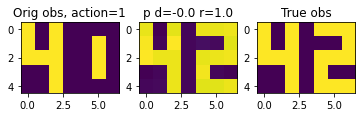

In [113]:
idx = np.random.choice(len(fx))
rew = round(l.normalizers['rew_y'].unnormalize(
    np.array([fnext_model[idx, l.feature_shape[0]:][0].item()]))[0], 2)
done = round(l.normalizers['done_y'].unnormalize(
    np.array([fnext_model[idx, l.feature_shape[0]:][1].item()]))[0], 2)
plt.subplot(1, 3, 1)
plt.title(f'Orig obs, action={np.argmax(ctx["action_x"][idx].numpy())}')
plt.imshow(unperm(l.normalizers['obs'].unnormalize(ctx['obs_x'])[idx].detach().cpu().numpy()))
plt.subplot(1, 3, 2)
plt.title(f"p d={done} r={rew}")
plt.imshow(unperm(obs_rec_denorm[idx]))
plt.subplot(1, 3, 3)
plt.title("True obs")
plt.imshow(unperm(l.normalizers['obs'].unnormalize(ctx['obs_y'])[idx].detach().cpu().numpy()))

In [127]:
rew_true = ctx['rew_y'].flatten().numpy()
rew_pred = fnext_model[:, l.feature_shape[0]:][:, 0].flatten().detach().numpy()

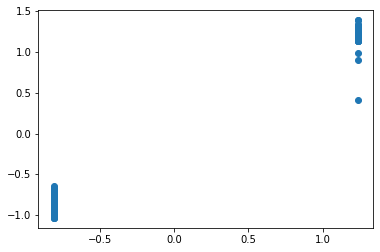

In [128]:
plt.scatter(rew_true, rew_pred)

In [129]:
done_true = ctx['done_y'].flatten().numpy()
done_pred = fnext_model[:, l.feature_shape[0]:][:, 1].flatten().detach().numpy()

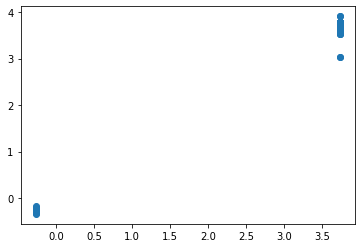

In [130]:
plt.scatter(done_true, done_pred)

In [134]:
obs_x_unnorm = l.normalizers['obs'].unnormalize(ctx['obs_x']).detach().cpu().numpy()

In [152]:
digits = [1. * digit_to_np(z) for z in range(22)]

In [157]:
obs = unperm(obs_x_unnorm[0])

In [158]:
d1 = obs[:, :3]
d2 = obs[:, 4:]

In [162]:
def decode_digit(d_given):
    return np.argmin([np.abs(d_given - digit).mean() for digit in digits])
d1 = decode_digit(d1)
d2 = decode_digit(d2)

3 4


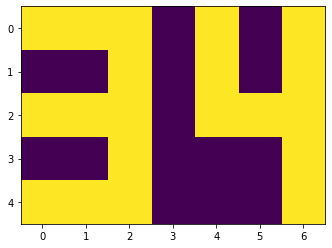

In [164]:
print(d1, d2)
plt.imshow(obs)

In [165]:
def get_f(obs_unnorm):
    obs = unperm(obs_unnorm)
    d1 = obs[:, :3]
    d2 = obs[:, 4:]
    d1 = decode_digit(d1)
    d2 = decode_digit(d2)
    return [d1, d2]

In [173]:
features = np.array([get_f(obs) for obs in obs_x_unnorm])

[3 5]


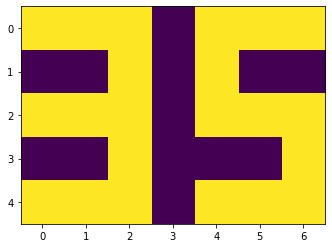

In [174]:
print(features[123])
plt.imshow(unperm(obs_x_unnorm[123]))

In [178]:
f_pred = l.decoder(ctx['obs_x']).detach().cpu().numpy()

In [184]:
df_pred = pd.DataFrame(f_pred, columns=['f1', 'f2', 'f3'])
df_true = pd.DataFrame(features, columns=['d1', 'd2'])

In [224]:
df_all = pd.concat([df_pred, df_true], axis=1)
df_all['step'] = df_all['d1'] + df_all['d2']
df_all['delta'] = df_all['d1'] - df_all['d2']

<AxesSubplot:>

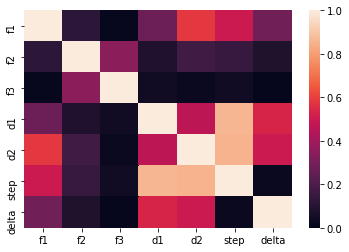

In [225]:
sns.heatmap(np.abs(df_all.corr()), vmin=0, vmax=1)

In [226]:
import statsmodels.api as sm
from patsy import dmatrices

In [230]:
y, X = dmatrices('step ~ f1 + f2 + f3', data=df_all, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   step   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     119.1
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           6.70e-66
Time:                        21:57:16   Log-Likelihood:                -2743.2
No. Observations:                1000   AIC:                             5494.
Df Residuals:                     996   BIC:                             5514.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2451      0.146     36.043      0.000       4.960       5.531
f1            -0.5528      0.031    -17.717      0.000      -0.614      -0.492
f2            -0.1427      0.034     -4.190      0.000      -0.209      -0.076
f3            -0.1023      0.031     -3.259      0.001      -0.164      -0.041
==============================================================================
Omnibus:                      161.559   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.086
Skew:                           0.399   Prob(JB):                     5.44e-14
Kurtosis:                       2.090   Cond. No.                         6.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

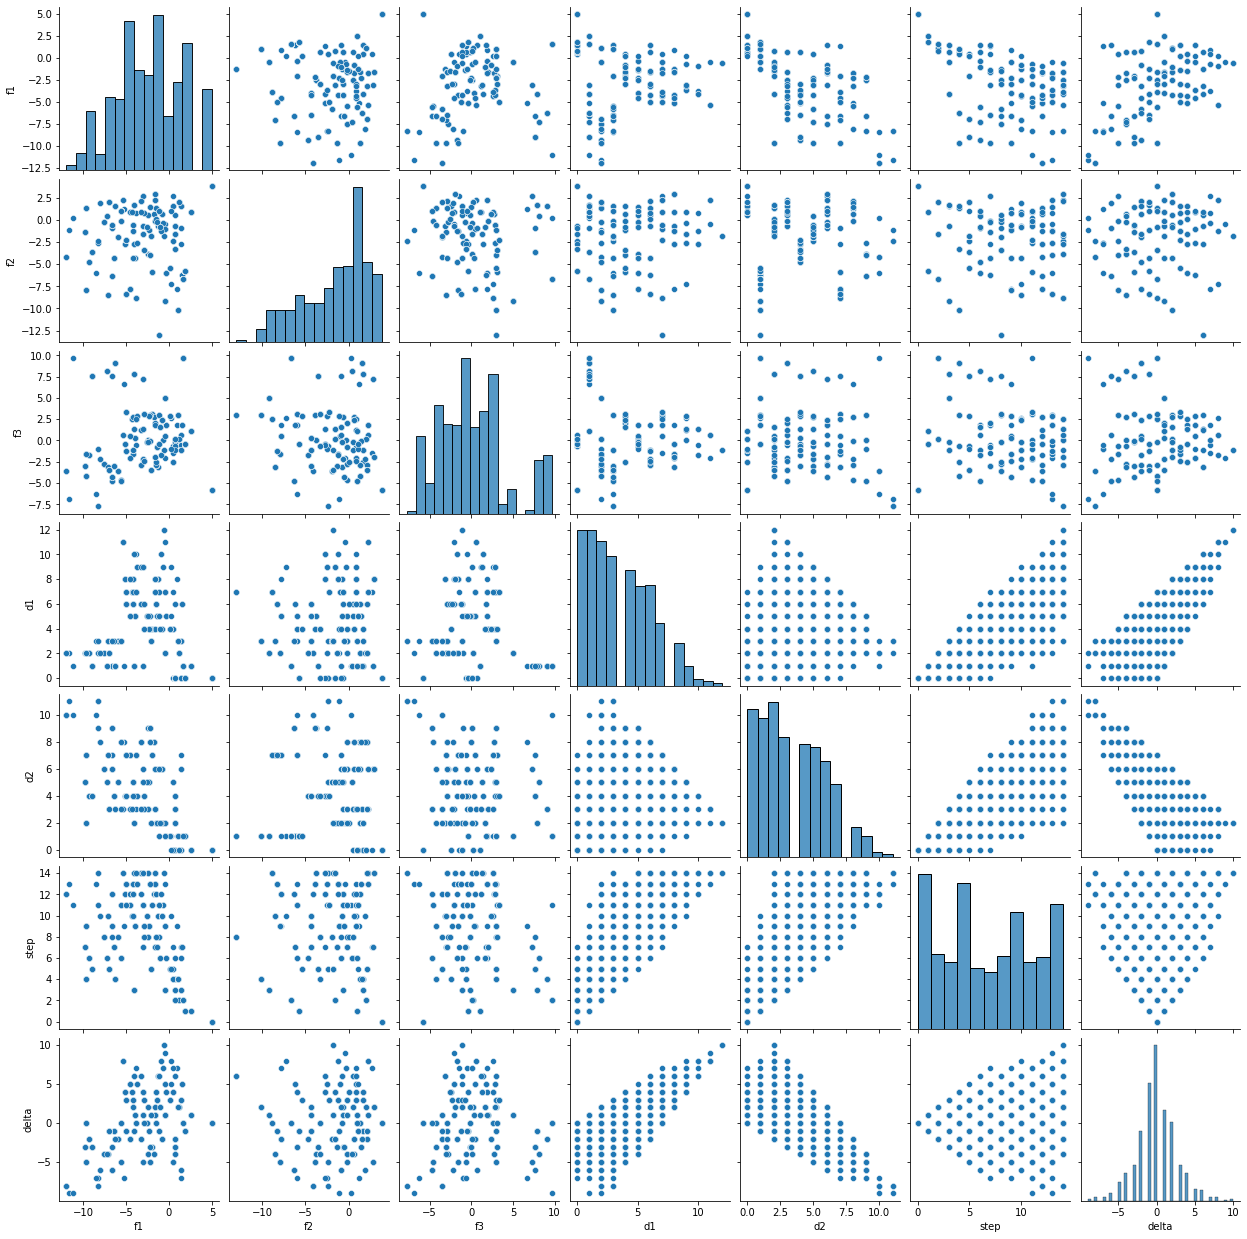

In [228]:
sns.pairplot(df_all)

In [247]:
import tensorflow as tf

In [248]:
m = tf.keras.Sequential([
    tf.keras.layers.Dense(50, input_shape=(3,), activation='tanh'),
    tf.keras.layers.Dense(25, activation='tanh'),
    tf.keras.layers.Dense(2, activation=None)
])
m.compile('adam', 'mse')

In [249]:
h = m.fit(np.array(df_pred), np.array(df_true), epochs=2000, verbose=0)

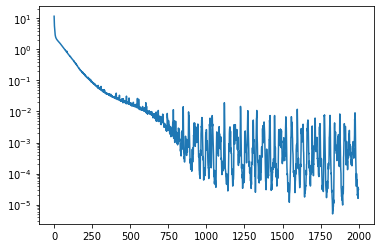

In [250]:
plt.plot(h.history['loss'])
plt.yscale('log')

In [251]:
# The model learns a pretty much random values for the features...
# trying post-features

In [252]:
f_pred_post = l.rot_pre(l.decoder(ctx['obs_x'])).detach().cpu().numpy()

In [256]:
df_pred = pd.DataFrame(f_pred_post, columns=['f1', 'f2', 'f3'])
df_true = pd.DataFrame(features, columns=['d1', 'd2'])

In [257]:
df_all = pd.concat([df_pred, df_true], axis=1)
df_all['step'] = df_all['d1'] + df_all['d2']
df_all['delta'] = df_all['d1'] - df_all['d2']

<AxesSubplot:>

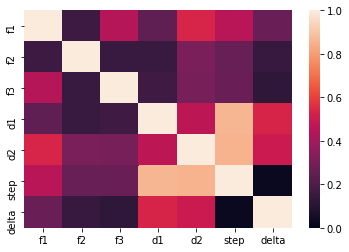

In [258]:
sns.heatmap(np.abs(df_all.corr()), vmin=0, vmax=1)

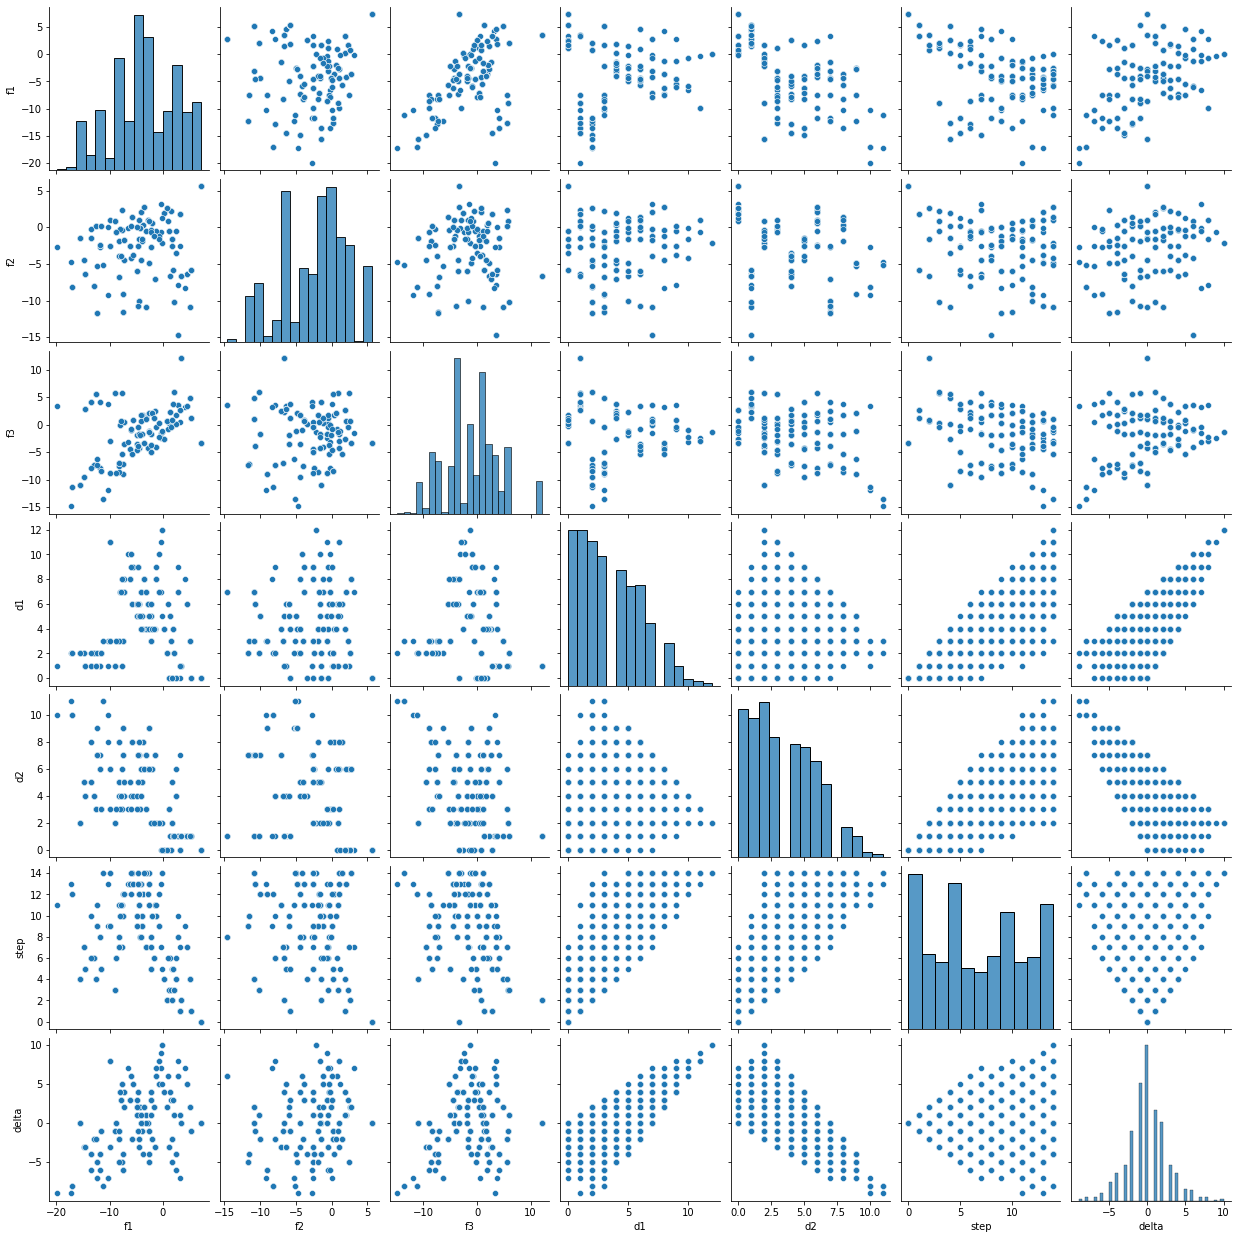

In [259]:
sns.pairplot(df_all)